In [17]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import scipy
import os

In [18]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess


In [19]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [20]:
refresh_rp_file = True

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_49": "1691041080",
}

if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_49 = download_sheet(rp_file_id, sheet_ids["data_10_49"])
    
    data = pd.concat([data_1_9, data_10_49], axis = 0)
    data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"], inplace=True)
    data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1}, inplace=True)
    data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''}, inplace=True)

    # data above 30 requires a 2nd ingredient to be valid.
    data.drop(  data.index[(data["Level"] >= 30) & (data["Amnt"] == 0.0)] , inplace=True )

    # data below 30 we clear 2nd ingredient
    data.loc[data["Level"] < 30, "Amnt"] = 0.0
    data.loc[data["Level"] < 30, "Ing2P"] = 0.0
    data.loc[data["Level"] < 30, "Ingredient 2"] = ""

    # data below 25 we clear 2nd skill, and below 10 we clear the 1st
    data.loc[data["Level"] < 25, "Sub Skill 2"] = ""
    data.loc[data["Level"] < 10, "Sub Skill 1"] = ""

    # avoid a bug in RP of freshly caught mon with skill up unlocked.
    # (We now trust the bugged data is quarantined so we can use the valid data)
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) )]
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) )]

    # only use data known to the Pokedex (we'll update Pokedex as needed)
    data.drop( data.index[~data["Pokemon"].isin( game.data.pokedex["Pokemon"]) ], inplace=True )
    
    data.to_pickle(fit_options.data_file)
    
else:
    
    data = pd.read_pickle(fit_options.data_file)


In [21]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.000000,6534.0,6534.000000,6534.000000,6534.000000,6534.000000
mean,10.853229,615.533364,1.502908,615.572189,0.038825,3944.459749,3791.715011,12.276094,28.061524,38.029691,109.003979,1.022954,0.988395,0.994858,1.000612,1.005326,0.207776,33.046729,55.868228,149.126645,1.0,0.078359,3.244873,0.987198,1.028745
std,7.311007,400.372168,0.995278,400.424290,0.985871,964.776439,1027.439788,3.398884,2.615911,8.230885,16.157611,0.305288,0.059258,0.044912,0.117631,0.118704,0.044995,36.934256,28.297937,61.165970,0.0,0.533277,21.530233,0.038346,0.071271
min,1.000000,245.000000,1.000000,245.060000,-11.980000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.880000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,356.000000,1.000000,356.392500,-0.290000,3200.000000,2934.360000,10.000000,26.000000,32.000000,98.000000,0.802500,1.000000,1.000000,1.000000,1.000000,0.180000,12.810000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,470.000000,1.000000,470.100000,-0.010000,3900.000000,3773.000000,12.000000,28.000000,36.000000,103.000000,0.950000,1.000000,1.000000,1.000000,1.000000,0.200000,20.190000,46.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,724.000000,2.000000,723.817500,0.270000,4500.000000,4443.750000,14.000000,31.000000,42.000000,115.000000,1.220000,1.000000,1.000000,1.000000,1.000000,0.240000,43.980000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3479.000000,6.000000,3479.540000,10.460000,6300.000000,6916.140000,23.000000,35.000000,83.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.950000,243.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.42,0.42,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.36,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.70,-0.30,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.09,0.09,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.90,-0.10,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.50,937.84,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.77,-0.23,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.21,750.21,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [22]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())


In [23]:
# Compute per sample information about help time, nature, sub-skills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    6534.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Helps per hour, dtype: float64

In [24]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"].to_numpy() - RP(x)

count    6534.000000
mean        1.496021
std         1.780526
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        40.000000
Name: RP, dtype: float64

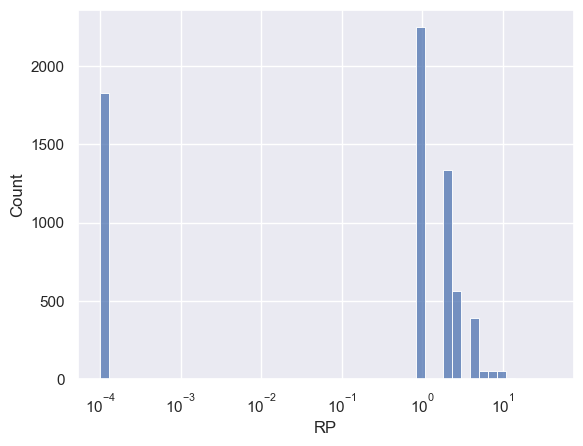

In [25]:
# what is the quality of the initial guess?

r = np.abs(data["RP"] - np.round(RP(x0)) )
pd.Series(r).describe()
_ = sns.histplot(x=np.clip(r, 1e-4,1e3), log_scale=True, bins=50)

In [26]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = fit_options.result_file(digest(data, x0))

if cache_fit and os.path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")

else:

    alphas = [1,6,12,18] if fit_options.progressive_soft_round_alpha else [0]
    x = x0
    opt = {}
    for alpha in alphas:
        fit_options.soft_round.exact = (alpha<=0)
        fit_options.soft_round.alpha = alpha
        opt = scipy.optimize.least_squares(residual, x, **fit_options.least_squares_kwargs)
        x = opt.x

    # save results and remove some stuff we don't need to save.
    if 'jac' in opt: del opt.jac
    if 'active_mask' in opt: del opt.active_mask
    if 'fun' in opt: del opt.fun
    if 'final_simplex' in opt: del opt.final_simplex

    save(filename, opt)

Loaded from cache


In [27]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.563e-01  2.544e-01 ...  2.212e-01  2.211e-01]
       cost: 895.6192997918448
       grad: [-1.035e-05 -1.478e-05 ...  0.000e+00  0.000e+00]
 optimality: 0.2867610949324444
       nfev: 39
       njev: 23

count    6534.000000
mean        0.135904
std         0.494469
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: RP, dtype: float64

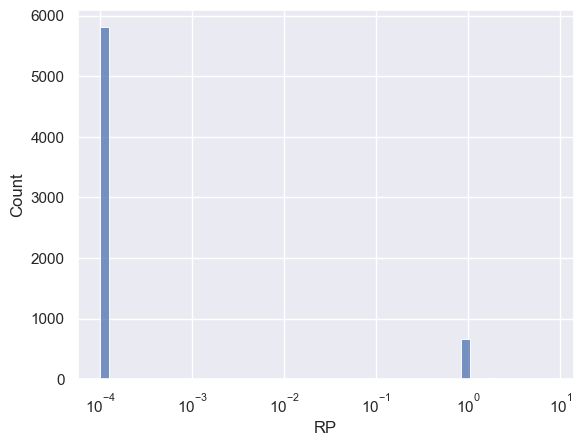

In [28]:
r_opt = np.abs(data["RP"] - np.round(RP(opt.x)) )
pd.Series(r_opt).describe()
_ = sns.histplot(x=np.clip(r_opt, 1e-4,1e3), log_scale=True, bins=50)

In [29]:
sol = unpack(opt.x, unpack_info)
table(sol)

Pokemons ing fractions,[0.25627069 0.25435273 0.26547669 ... 0.18068135 0.20049464 0.21552141]
Pokemons skill products,[16.70635191 16.7096484 18.47765029 ... 44.65931984 12.7832173 15.57111803]
Charge Strength S,[0.74631717 0.32265112]
Charge Strength M,[0.74532277 0.32270559]
Ingredient Magnet S,[0.74567107 0.322581 ]
Cooking Power-Up S,[0.74566714 0.32249508]
Extra Helpful S,[0.74562609 0.32236848]
Charge Energy S,[0.74829661 0.32196242]
Energizing Cheer S,[0.74710545 0.32170955]
Energy for Everyone S,[0.74575534 0.32286397]
Dream Shard Magnet S,[0.74481744 0.32244872]


In [30]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":game.data.pokedex["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.627069,16.706352
Ivysaur,25.435273,16.709648
Venusaur,26.547669,18.477650
Charmander,20.038515,9.673458
Charmeleon,22.665938,14.052051
Charizard,22.336963,14.127175
Squirtle,27.011931,17.601401
Wartortle,27.030861,17.588427
Blastoise,27.422660,18.460715


In [31]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in game.data.mainskills.to_dict(orient='records') :
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.422901,1.421160,1.421470,1.421218,1.420780,1.424711,1.421724,1.422435,1.419467,1.421824
3,1.964718,1.962421,1.962604,1.962088,1.961235,1.965863,1.961245,1.964493,1.959580,1.963407
4,2.712850,2.709826,2.709742,2.708796,2.707276,2.712563,2.705507,2.713117,2.705208,2.711283
5,3.745859,3.741887,3.741304,3.739678,3.737105,3.742883,3.732203,3.747025,3.734551,3.744030
6,5.172221,5.167017,5.165569,5.162880,5.158675,5.164554,5.148515,5.174932,5.155562,5.170158


In [32]:
# What are the worst points?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = data["RP"] - np.round(RP(opt.x))
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False).reset_index(drop=True)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
0,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1520.287724,8.0,64.0
1,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1432.189269,8.0,64.0
2,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1273.587900,8.0,64.0
3,Charizard,CharizardNeutral273Inventory Up MHelping Speed M,27.0,3.0,-,-,Inventory Up M,Helping Speed M,1299.0,1292.336732,7.0,49.0
4,Sylveon,SylveonRelaxed102Helping bonus,10.0,2.0,Energy Recovery,EXP Gains,Helping bonus,,1023.0,1015.774675,7.0,49.0
5,Absol,AbsolHasty171Helping Speed S,17.0,1.0,EXP Gains,Energy Recovery,Helping Speed S,,672.0,666.418120,6.0,36.0
6,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1755.178655,6.0,36.0
7,Charizard,CharizardMild276Skill Level Up MHelping Speed M,27.0,6.0,Ingredient Finding,Energy Recovery,Skill Level Up M,Helping Speed M,1514.0,1507.595964,6.0,36.0
8,Butterfree,ButterfreeNeutral103Sleep EXP Bonus,10.0,3.0,-,-,Sleep EXP Bonus,,843.0,837.200879,6.0,36.0
9,Butterfree,ButterfreeImpish105Skill Level Up M,10.0,5.0,Energy Recovery,Ingredient Finding,Skill Level Up M,,901.0,894.698029,6.0,36.0
